In [93]:
import creds
import matplotlib.pyplot as plt
from cointegration.funcs import * 
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
from statsmodels.tsa.stattools import adfuller as adf
import scipy.optimize as spo
from pykalman import KalmanFilter

Time Series1:  0.5% is missing (425135 ==> 423020)
Time Series2:  1.2% is missing (428263 ==> 423020)


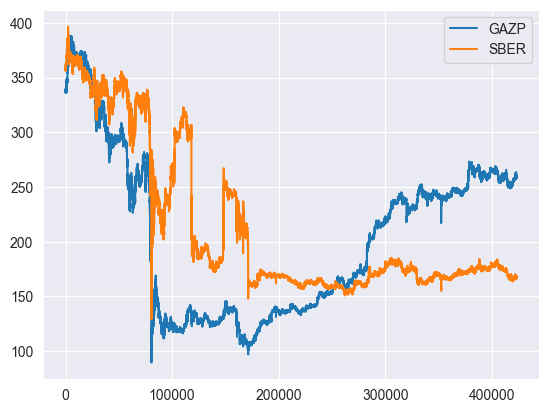

,time,figi,ticker,lot,currency,instrument_type,open,high,low,close,volume
0,2021-10-01 07:00:00+00:00,BBG004730N88,SBER,10,rub,share,339.21,339.21,338.38,338.89,59807
1,2021-10-01 07:01:00+00:00,BBG004730N88,SBER,10,rub,share,338.78,339.94,338.40,339.77,34872
2,2021-10-01 07:02:00+00:00,BBG004730N88,SBER,10,rub,share,339.65,339.92,339.27,339.64,16531
3,2021-10-01 07:03:00+00:00,BBG004730N88,SBER,10,rub,share,339.60,339.75,338.50,338.67,31452
4,2021-10-01 07:04:00+00:00,BBG004730N88,SBER,10,rub,share,338.67,338.80,338.21,338.73,38226
...,...,...,...,...,...,...,...,...,...,...,...
423015,2023-09-30 15:54:00+00:00,BBG004730N88,SBER,10,rub,share,258.53,260.79,258.53,260.79,102
423016,2023-09-30 15:55:00+00:00,BBG004730N88,SBER,10,rub,share,260.98,261.00,260.98,261.00,11
423017,2023-09-30 15:56:00+00:00,BBG004730N88,SBER,10,rub,share,258.92,260.99,258.88,260.99,23
423018,2023-09-30 15:57:00+00:00,BBG004730N88,SBER,10,rub,share,261.02,261.02,258.91,258.91,10


In [94]:
data = pd.read_csv('../correlation/SBER_GAZP.csv')

s1 = data.loc[data['ticker'] == 'SBER']
s2 = data.loc[data['ticker'] == 'GAZP']

s1, s2 = match_ts(s1, s2)

plt.plot(s1['close'], label='GAZP')
plt.plot(s2['close'], label='SBER')
plt.legend()
plt.show()
s1

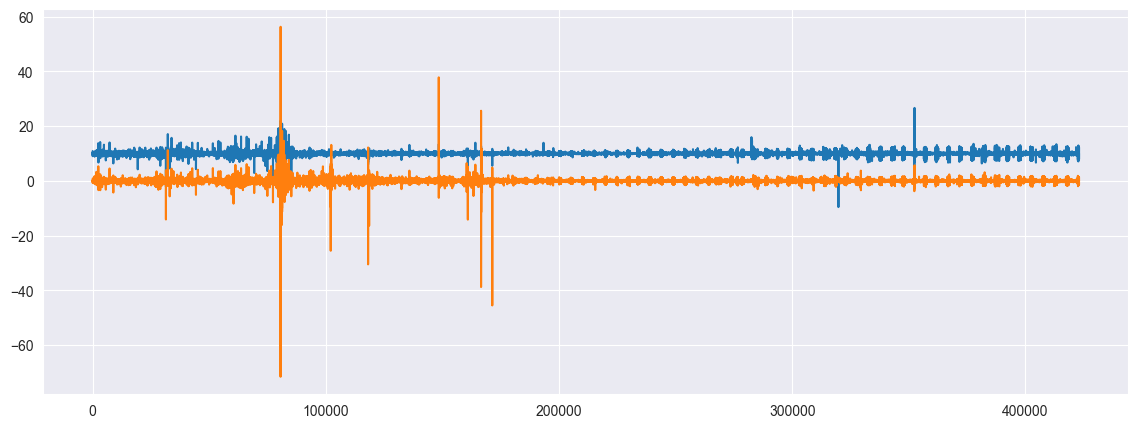

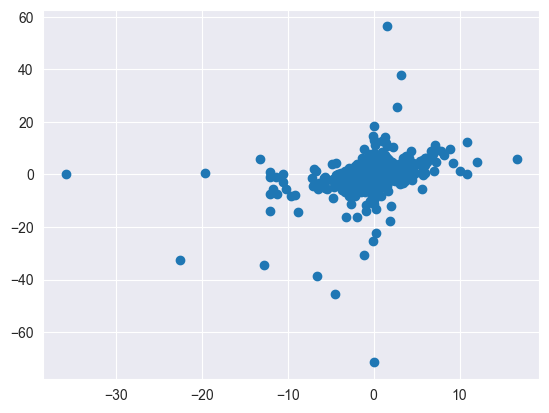

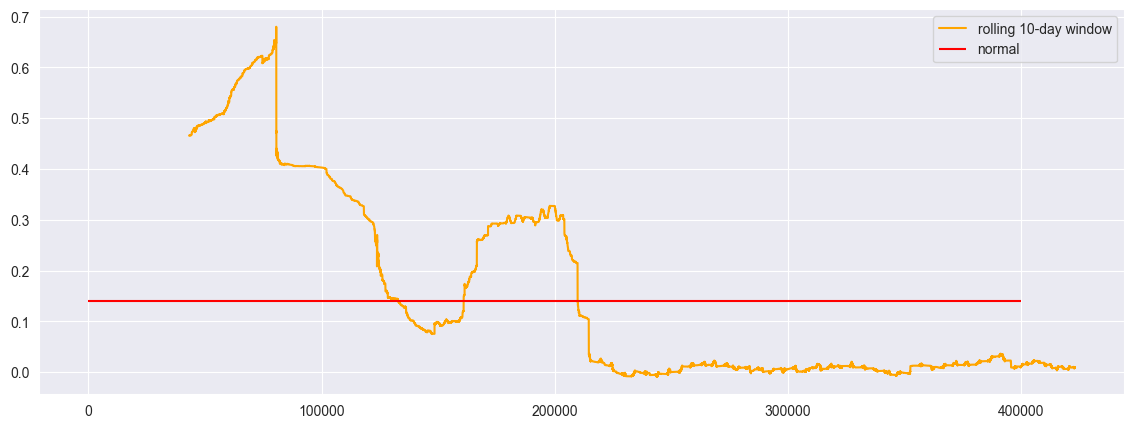

In [95]:
ss1 = pd.Series(np.diff(s1.close))
ss2 = pd.Series(np.diff(s2.close))

plt.figure(figsize=(14, 5))
plt.plot(ss1+10)
plt.plot(ss2)
plt.show()


plt.plot(ss1, ss2, 'o')
plt.show()


plt.figure(figsize=(14, 5))
plt.plot(ss1.rolling(30*24*60).corr(ss2), label='rolling 10-day window', color='orange')
plt.hlines(np.corrcoef(ss1, ss2)[0][1], xmin=0, xmax=400000, label='normal', color='red')
plt.legend()
plt.show()

In [ ]:
from filterpy.kalman import KalmanFilter

In [96]:
def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs

def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the 
    Kalman Filter calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0], 
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()
    
    
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the 
    changing relationship between the sets of prices    
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')    
    colours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]], 
        s=30, c=colours, cmap=colour_map, 
        edgecolor='k', alpha=0.8
    )
    
    # Add a colour bar for the date colouring and set the 
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

In [99]:
prices = pd.DataFrame({'SBER': ss1.values, 'GAZP': ss2.values})
etfs = ['SBER', 'GAZP']

# state_means, state_covs = calc_slope_intercept_kalman(names, prices)
# draw_slope_intercept_changes(prices, state_means)

In [101]:
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack(
    [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
).T[:, np.newaxis]

kf = KalmanFilter(
    n_dim_obs=1, 
    n_dim_state=2,
    initial_state_mean=np.zeros(2),
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=1.0,
    transition_covariance=trans_cov
)
    
state_means, state_covs = kf.filter(prices[etfs[1]].values)


state_means

ValueError: object has no __init__ method

In [ ]:
# print(np.corrcoef(s1, s2))
# print(np.corrcoef(np.diff(s1), np.diff(s2)))

In [ ]:
# A = np.array((np.ones_like(s1), s1))
# A = s1
# lp = s2
# 
# res = np.linalg.lstsq(A.T, lp, rcond=None)
# print(f'Coefs: {res[0]}')
# b = res[0]
# 
# print(b / np.std(s1) / np.std(s2))